- Create new datasets with images of different resolutions # Problem converting from numpy to image file using PIL
- Filter the data # Done
- Train efficientNetB0 using pretrained weights and also train from scratch
- Also perform data augmentation to see its impact

In [1]:
# Importing libraries
import numpy as np
import tensorflow as tf
import os
import pathlib
import pydicom
import warnings
import PIL
import logging
import pandas as pd
from sklearn.model_selection import GroupKFold
warnings.filterwarnings('ignore')
os. environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings


In [2]:
PATH = pathlib.Path('D:\Datasets')
DATA_PATH = os.path.join(PATH,'siim_covid19_detection', '320px\\train\\study')
data_dir = pathlib.Path(DATA_PATH)

In [3]:
contrasts = []
for path in list(data_dir.glob('*')):
    img = PIL.Image.open(path)
    img =  np.asarray(img)
    contrasts.append((path, np.max(img) - np.min(img)))

In [4]:
only_contrasts = [i[1] for i in contrasts]

In [5]:
only_contrasts.index(min(only_contrasts))

225

In [6]:
sorted(only_contrasts)

[30,
 84,
 92,
 104,
 108,
 112,
 112,
 115,
 117,
 122,
 122,
 122,
 124,
 125,
 128,
 128,
 129,
 131,
 133,
 133,
 134,
 135,
 140,
 140,
 140,
 141,
 142,
 142,
 142,
 143,
 143,
 143,
 143,
 143,
 143,
 143,
 143,
 143,
 143,
 143,
 143,
 143,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 144,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 146,
 146,
 146,
 146,
 146,
 146,
 146,
 146,
 146,
 146,
 146,
 146,
 146,
 146,
 146,
 146,
 146,
 146,
 146,
 147,
 147,
 147,
 147,
 147,
 147,
 147,
 147,
 147,
 147,
 147,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 151,
 151,
 151,
 151,
 151,
 151,
 151,
 151,
 151,
 152,
 152,
 152,
 152,
 152,
 152,
 152,
 152,
 153,
 153,
 153,
 153,
 153,
 153,
 153,
 153,
 153,
 154,
 155,
 

In [37]:
ind = only_contrasts.index(133)

In [38]:
sample_img = PIL.Image.open(contrasts[ind][0])

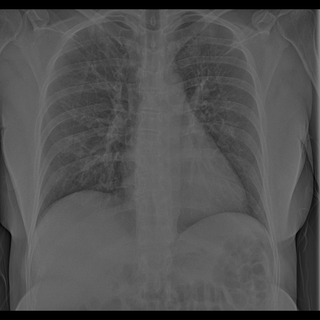

In [39]:
sample_img

In [40]:
img = tf.io.read_file(str(contrasts[ind][0]))
img = tf.image.decode_png(img, channels = 3)
# img =  tf.image.grayscale_to_rgb(img)

In [41]:
img.numpy().min(), img.numpy().max()

(0, 133)

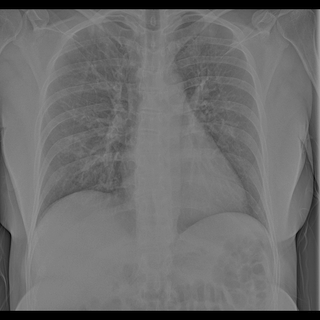

In [43]:
PIL.Image.fromarray(tf.image.adjust_gamma(img,0.73).numpy())

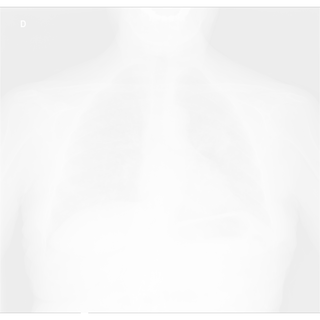

In [126]:
sample_img

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, 'study.csv'))

label_columns = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5999 entries, 0 to 5998
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        5999 non-null   object
 1   boxes                     4294 non-null   object
 2   label                     5999 non-null   object
 3   StudyInstanceUID          5999 non-null   object
 4   Negative for Pneumonia    5999 non-null   int64 
 5   Typical Appearance        5999 non-null   int64 
 6   Indeterminate Appearance  5999 non-null   int64 
 7   Atypical Appearance       5999 non-null   int64 
 8   label class               5999 non-null   object
 9   rows                      5999 non-null   int64 
 10  columns                   5999 non-null   int64 
 11  Multi_image_bool          5999 non-null   bool  
dtypes: bool(1), int64(6), object(5)
memory usage: 521.5+ KB


In [5]:
#create folds
gkf  = GroupKFold(n_splits = 5)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(df, groups = df.index.tolist())):
    df.loc[val_idx, 'fold'] = fold
    print(len(train_idx), len(val_idx))

4799 1200
4799 1200
4799 1200
4799 1200
4800 1199


In [6]:
# Process an image path
def process_path(file_path):
    image_name = tf.strings.split(file_path, os.path.sep).numpy()[-1].decode()
    image_id = image_name.split('.')[0]
    label = tf.cast((df.loc[df['id'] == image_id][label_columns]).values[0], dtype = tf.int16)
#     print('Image Name', image_name,'\n')
#     print('File Path', file_path.numpy())
    # Loading the image
    img = pydicom.dcmread(file_path.numpy().decode())
    img = img.pixel_array
    # print(img.shape)
    # Resizing the image
    img = img[:,:,None]
    img = tf.image.resize(img, [320,320])
    if img.numpy().max() > 256:
        img = img/65535
    else:
        img = img/255
    # img = tf.cast(img, dtype = tf.int16)
    return img, label

In [7]:
# Storing all the file names
train_dir = pathlib.Path(os.path.join(data_dir, 'train'))
train_image_paths = list(train_dir.glob('*/*/*.dcm'))

len(train_image_paths)

6334

In [8]:
train_image_paths = [path for path in train_image_paths if str(path).split(os.sep)[-1].split('.')[0] in list(df.id)]

In [9]:
len(train_image_paths)

5999

In [10]:
def get_paths(ids, all_paths):
    paths = [path for path in all_paths if str(path).split(os.sep)[-1].split('.')[0] in ids]
    return paths